Условие.

Детектирование приступа эпилепсии по данным электроэнцефалограммы (EEG) - извлечение признаков и бинарная классификация.
Сначала про первую задачку - EEG считывает электрические сигналы мозга и позволяет понять, насколько активен мозг в данный момент. Приступ эпилепсии характеризуется аномальной активностью мозга, которую можно попытаться задетектировать при помощи EEG, что мы и будем делать в рамках первой задачи.

- Скачайте данные из репозитория - https://www.kaggle.com/datasets/harunshimanto/epileptic-seizure-recognition
альтернативный вариант ссылки:
https://raw.githubusercontent.com/BakerWade/Epileptic-Seizure-recognition/refs/heads/main/Epileptic%20Seizure%20recognition/data.csv

- Проведите EDA, а также трансформируйте целевую переменную из многоклассовой в бинарную - класс 1 (приступ) против всех остальных и отложите 20% данных для тестирования (не забудьте про стратификацию).

- Постройте бейзлайн, используя сырые данные в качестве признаков, без дополнительной предобработки. В качестве модели (или даже моделей) можете выбрать любой полюбившийся вам алгоритм.

- Так как каждый временной ряд представляет собой сигнал из 178 наблюдений, пришедших за 1 секунду, имеет смысл попробовать методы извлечения признаков из сигналов. Извлеките FFT и Wavelet признаки и снова обучите модель/модели и проверьте качество.

- Наконец, при помощи библиотеки для автоматического извлечения признаков из временных рядов сгенерируйте статистические признаки и снова проверьте качество моделей.

Какой из подходов показал лучшее качество?

# IMPORTS

In [1]:
import pandas as pd
import numpy as np
import pywt
import tsfel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

# DATA

In [3]:
url = "https://raw.githubusercontent.com/BakerWade/Epileptic-Seizure-recognition/refs/heads/main/Epileptic%20Seizure%20recognition/data.csv"
data = pd.read_csv(url)
data.rename(columns={"Unnamed: 0": "ID"}, inplace=True)
data.head(2)

,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1


# EDA

Проведите EDA, а также трансформируйте целевую переменную из многоклассовой в бинарную - класс 1 (приступ) против всех остальных и отложите 20% данных для тестирования (не забудьте про стратификацию).

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 180 entries, ID to y
dtypes: int64(179), object(1)
memory usage: 15.8+ MB


In [ ]:
# describe() слишком нечитабельно получается иззи большого количесва точек

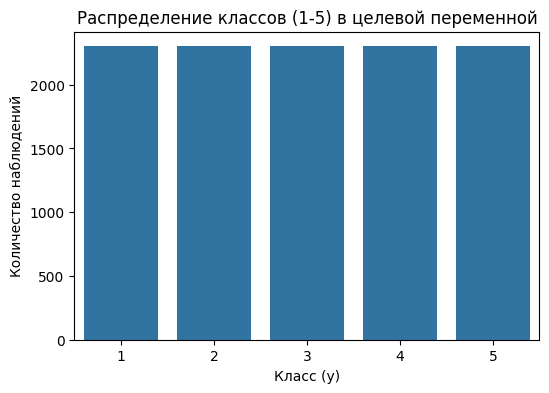

In [5]:
# Распределение всех пяти классов в целевой переменной
plt.figure(figsize=(6, 4))
sns.countplot(x='y', data=data)
plt.title("Распределение классов (1-5) в целевой переменной")
plt.xlabel("Класс (y)")
plt.ylabel("Количество наблюдений")
plt.show()

In [6]:
data.y.value_counts()

y
4    2300
1    2300
5    2300
2    2300
3    2300
Name: count, dtype: int64

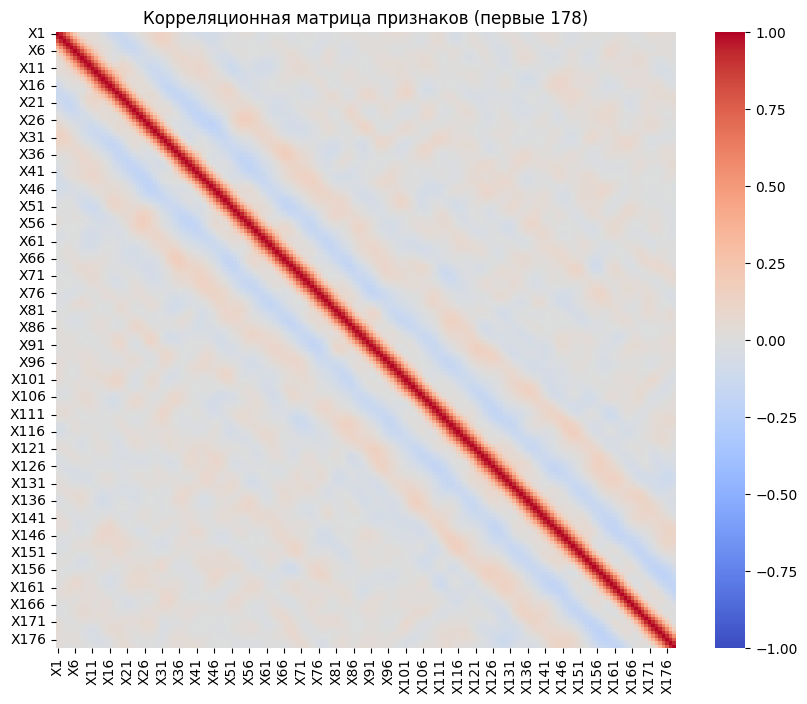

In [7]:
# Корреляционный анализ признаков (первые 178)
plt.figure(figsize=(10, 8))
correlation_matrix = data.iloc[:, 1:179].corr()  # исключаем ID и целевой класс
sns.heatmap(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Корреляционная матрица признаков (первые 178)")
plt.show()

In [8]:
data['y'] = data['y'].apply(lambda x: 1 if x == 1 else 0)
X = data.drop(columns=['y', 'ID'])
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# MODEL BASELINE

Постройте бейзлайн, используя сырые данные в качестве признаков, без дополнительной предобработки. В качестве модели (или даже моделей) можете выбрать любой полюбившийся вам алгоритм.

In [9]:
def get_results(param_grid, X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_
    
    print("Лучшие параметры:", grid_search.best_params_)
    print("Лучшее значение F1-Score на кросс-валидации:", grid_search.best_score_)
    
    # ---------------------- train evaluate---------------------------------------
    y_train_pred = best_rf.predict(X_train)
    y_train_proba = best_rf.predict_proba(X_train)[:, 1]
    
    print("\nОтчет классификации на обучающих данных:")
    print(classification_report(y_train, y_train_pred))
    print("F1-Score на обучающих данных:", f1_score(y_train, y_train_pred))
    print("ROC-AUC на обучающих данных:", roc_auc_score(y_train, y_train_proba))
    
    # ---------------------- test evaluate---------------------------------------
    y_test_pred = best_rf.predict(X_test)
    y_test_proba = best_rf.predict_proba(X_test)[:, 1]
    
    print("\nОтчет классификации на тестовых данных:")
    print(classification_report(y_test, y_test_pred))
    print("F1-Score на тестовых данных:", f1_score(y_test, y_test_pred))
    print("ROC-AUC на тестовых данных:", roc_auc_score(y_test, y_test_proba))
    
    return best_rf

In [10]:
# на сырых данных

In [11]:
param_grid = {
    'n_estimators': [250, 300, 350],
    'max_depth': [25, 30, 35],
    'min_samples_split': [1, 2],
    'min_samples_leaf': [2, 3]
}

get_results(param_grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Лучшие параметры: {'max_depth': 35, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 250}
Лучшее значение F1-Score на кросс-валидации: 0.9330453536930978

Отчет классификации на обучающих данных:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7360
           1       1.00      0.99      0.99      1840

    accuracy                           1.00      9200
   macro avg       1.00      0.99      1.00      9200
weighted avg       1.00      1.00      1.00      9200

F1-Score на обучающих данных: 0.9937141295435912
ROC-AUC на обучающих данных: 0.9998513557419659

Отчет классификации на тестовых данных:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1840
           1       0.95      0.93      0.94       460

    accuracy                           0.98      2300
   macro avg       0.97      0.96      0.96  

RandomForestClassifier(max_depth=35, min_samples_leaf=2, n_estimators=250,
                       random_state=42)

==============================================================================================================

- Так как каждый временной ряд представляет собой сигнал из 178 наблюдений, пришедших за 1 секунду, имеет смысл попробовать методы извлечения признаков из сигналов. Извлеките FFT и Wavelet признаки и снова обучите модель/модели и проверьте качество.

# FTT

In [12]:
def extract_fft_features(X, n_components=10):
    fft_features = []
    for row in X:
        # Выполняем FFT для строки (временного ряда)
        fft_vals = np.fft.fft(row)
        # Извлекаем амплитуды первых n_components частотных компонент
        fft_amplitudes = np.abs(fft_vals)[:n_components]
        fft_features.append(fft_amplitudes)
    
    return np.array(fft_features)

In [13]:
X_train_fft = extract_fft_features(X_train.values, n_components=10)
X_test_fft = extract_fft_features(X_test.values, n_components=10)

param_grid = {
    'n_estimators': [300, 350, 400],
    'max_depth': [16, 18, 20],
    'min_samples_split': [4, 5],
    'min_samples_leaf': [1, 2]
}

get_results(param_grid, X_train_fft, y_train, X_test_fft, y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Лучшие параметры: {'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 350}
Лучшее значение F1-Score на кросс-валидации: 0.9417209623173411

Отчет классификации на обучающих данных:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7360
           1       1.00      1.00      1.00      1840

    accuracy                           1.00      9200
   macro avg       1.00      1.00      1.00      9200
weighted avg       1.00      1.00      1.00      9200

F1-Score на обучающих данных: 0.9983677910772579
ROC-AUC на обучающих данных: 0.9999972678402647

Отчет классификации на тестовых данных:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1840
           1       0.93      0.95      0.94       460

    accuracy                           0.98      2300
   macro avg       0.96      0.97      0.96  

RandomForestClassifier(max_depth=18, min_samples_split=5, n_estimators=350,
                       random_state=42)

=============================================================================================================

# WAVELET

In [14]:
def extract_wavelet_features(X, wavelet='db1', level=3):
    wavelet_features = []
    for row in X:
        coeffs = pywt.wavedec(row, wavelet, level=level)
        
        features = []
        for coeff in coeffs:
            features.extend([
                np.mean(coeff),          
                np.std(coeff),          
                np.max(coeff),           
                np.min(coeff)
            ])
        wavelet_features.append(features)
    
    return np.array(wavelet_features)

In [15]:
X_train_wavelet = extract_wavelet_features(X_train.values, wavelet='db1', level=3)
X_test_wavelet = extract_wavelet_features(X_test.values, wavelet='db1', level=3)

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [14, 15, 16],
    'min_samples_split': [4, 5],
    'min_samples_leaf': [1, 2]
}
get_results(param_grid, X_train_wavelet, y_train, X_test_wavelet, y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Лучшие параметры: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Лучшее значение F1-Score на кросс-валидации: 0.9552567415920332

Отчет классификации на обучающих данных:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7360
           1       1.00      1.00      1.00      1840

    accuracy                           1.00      9200
   macro avg       1.00      1.00      1.00      9200
weighted avg       1.00      1.00      1.00      9200

F1-Score на обучающих данных: 0.9986401958118031
ROC-AUC на обучающих данных: 0.9999981539461249

Отчет классификации на тестовых данных:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1840
           1       0.95      0.96      0.95       460

    accuracy                           0.98      2300
   macro avg       0.97      0.97      0.97  

RandomForestClassifier(max_depth=16, min_samples_split=5, n_estimators=150,
                       random_state=42)

===================================================================

При помощи библиотеки для автоматического извлечения признаков из временных рядов сгенерируйте статистические признаки и снова проверьте качество моделей.

# TSFEL

In [16]:
cfg = tsfel.get_features_by_domain()

X_train_tsfel = pd.DataFrame()
X_test_tsfel = pd.DataFrame()

for i in tqdm(range(X_train.shape[0])):
    row_features = tsfel.time_series_features_extractor(cfg, X_train.iloc[i, :].values, verbose=0)
    X_train_tsfel = pd.concat([X_train_tsfel, row_features], ignore_index=True)

for i in tqdm(range(X_test.shape[0])):
    row_features = tsfel.time_series_features_extractor(cfg, X_test.iloc[i, :].values, verbose=0)
    X_test_tsfel = pd.concat([X_test_tsfel, row_features], ignore_index=True)

X_train_tsfel.fillna(0, inplace=True)
X_test_tsfel.fillna(0, inplace=True)

  0%|          | 0/9200 [00:00<?, ?it/s]

  0%|          | 0/2300 [00:00<?, ?it/s]

In [17]:
param_grid = {
    'n_estimators': [80, 100, 120],
    'max_depth': [14, 15, 16],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]
}
get_results(param_grid, X_train_tsfel, y_train, X_test_tsfel, y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Лучшие параметры: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Лучшее значение F1-Score на кросс-валидации: 0.9742547904583552

Отчет классификации на обучающих данных:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7360
           1       1.00      1.00      1.00      1840

    accuracy                           1.00      9200
   macro avg       1.00      1.00      1.00      9200
weighted avg       1.00      1.00      1.00      9200

F1-Score на обучающих данных: 1.0
ROC-AUC на обучающих данных: 1.0

Отчет классификации на тестовых данных:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1840
           1       0.98      0.97      0.97       460

    accuracy                           0.99      2300
   macro avg       0.98      0.98      0.98      2300
weighted avg       0.

RandomForestClassifier(max_depth=15, random_state=42)

====================================================================================================|

лучшие результаты показала модель на признаках, полученных с помощью библиотеки tsfel
====================================================================================================|